# **Homework 7**

Due: **November 19, 5pm** (late submission until November 22nd, 5pm -- no submission possible afterwards)

Coding assignment: 25 points

Project report: 20 points

### Name: [Yawen Tan]

### Link to the github repo: [https://github.com/IsabellaTan/Brown-DATA2060-HW7]

#### Run the evironment test below, make sure you get all green checks! If not, you will lose 2 points for each red or missing flag.

In [3]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.11"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.11"):
    print(FAIL, "Python version 3.12.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'matplotlib': "3.10.5", 'numpy': "2.3.2",'sklearn': "1.7.1", 
                'pandas': "2.3.2", 'pytest': "8.4.1", 'torch':"2.7.1"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.11

[ OK ] matplotlib version 3.10.5 is installed.
[ OK ] numpy version 2.3.2 is installed.
[ OK ] sklearn version 1.7.1 is installed.
[ OK ] pandas version 2.3.2 is installed.
[ OK ] pytest version 8.4.1 is installed.
[ OK ] torch version 2.7.1 is installed.


# **Programming Assignment** (25 points)

### Introduction 

In this assignment, you will be implementing an SVM to solve binary
classification problems. While some modern solvers use gradient-based
methods to train the SVM, you will be using a Python quadratic
programming library, `quadprog` as an optimizer.

### Stencil Code & Data

We have provided the following stencils:

-   `Model` contains the `SVM` model that you will be implementing.

-   `Check Model` contains a series of tests to ensure you are coding your 
    model properly.

-   `QP` contains a `quadprog` wrapper function, `solve_QP`, which
    can efficiently solve quadratic programs.

-   `Main` is the entry point of your program, which will read in the
    data, run the classifiers and print the results.

You should *not* modify any code in `Main` or `QP` (with one
exception below). The autograder will use the unmodified version of
these two scripts. All the functions you need to fill in reside in
`Model`, marked by `TODO`s. You can change the data path in `Main` to use
different datasets to train the SVM.

### Fake Datasets

We've provided two fake datasets, `fake-data1.csv` and `fake-data2.csv`,
for you to train your SVM classifier with. Both datasets contains only
two dimensional data so that you can easily plot the data if you like.
`Main` converts the labels into $\{-1, 1\}$. The first fake dataset
is linearly separable while the second is not. You should use the fake
datasets for debugging purposes.

### Spambase Dataset

You will also be testing your SVM classifier on a real world dataset,
the Spambase dataset. You can find more details on the dataset
[here](https://archive.ics.uci.edu/ml/datasets/spambase). We will
only be using a subset of the full dataset.

## **The Assignment**

### **Quadratic Program Review**

Quadratic programs are a specific type of optimization problem. Each
quadratic program consists of an objective function and a set of
constraints. The objective function is the term that is being optimized,
and the constraints are inequalities that limit the possible values our
decision variables (the variables we are solving for) can take.

The objective function of a quadratic program has the form:
$$
\text{Minimize}\frac{1}{2}x^{\text{T}}Qx + c^{\text{T}}x
$$ 
The constraints have the form:

$$
Ax \leq b
$$ 

In these equations, Q, c, A, and b are constants that
define the problem, and $x$ is the variable that we would like to solve
for.

### **Example**

Let's see how formulating the matrices (Q and A) and vectors (c and b)
would work in an example. Let
$x = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$ be a two-dimensional
vector. Let's say we have the following:

$$\begin{aligned}
    \text{minimize } &3x_1^2 + 2x_1x_2 + x_2^2 - 6x_1 + 4x_2 \\
    \text{subject to: }&3x_1 - x_2 \geq 5 \\
    &2x_2 \leq 6 \\
    &x_2-x_1 \leq -1 \\
    &x_1, x_2 \geq 0 \\
\end{aligned}$$ 
We can reformat the objective function by defining $c = \begin{pmatrix} -6 \\ 4 \end{pmatrix}$ giving us $-6x_1 + 4x_2 = c^Tx$. We can also pull out a $\frac{1}{2}$ from the quadratic terms, leaving us with:
$$\frac{1}{2}(6x_1^2 + 4x_1x_2 + 2x_2^2) +c^Tx$$

We can define $Q = \begin{pmatrix} 6 & z \\ 4-z & 2 \end{pmatrix}$
with $z \in \mathbb{R}$ (z can be any real number) giving us
$6x_1^2 + 4x_1x_2 + 2x_2^2 = x^TQx$. Thus our objective function is now
in the form we wish: $$\frac{1}{2}x^TQx + c^Tx$$\
In order to format the inequality constraints, we must first format all
constraints to be less than or equal to constraints. Therefore, for any
constraint of the form $ax_1 + bx_2 \geq c$, we must flip the inequality
by multiplying both sides by -1. The example before would yield
$-ax_1-bx_2 \leq -c$. Thus we perform this on all greater than or equal
to constraints, giving us: $$\begin{aligned}
    -3x_1+x_2 &\leq -5 \\
    2x_2 &\leq 6 \\
    -x_1 + x_2 &\leq -1 \\
    -x_1 &\leq 0 \\
    -x_2 &\leq 0 \\
\end{aligned}$$ Each row of A will correspond to the coefficients of x
of a constraint while each element of b is the constraint itself. For
example, the first row of A could be $\begin{pmatrix} -3 & 1 \end{pmatrix}$
and the first element of b would be -5. We can have 
$A = \begin{pmatrix} -3 & 1 \\ 0 & 2 \\ -1 & 1 \\ -1 & 0 \\ 0 & -1\end{pmatrix}$
and $b = \begin{pmatrix} -5 \\ 6 \\ -1 \\ 0 \\ 0 \end{pmatrix}$. 
Thus our original problem is now of the form required: 
$$Ax \leq b$$
Thus our problem has been converted to the form we wanted, with Q, c, A,
and b defined so that we achieve that form.

### **Quadprog**

We will be using the Python library `quadprog` to solve quadratic
programs. You do not need to call any of the methods provided by
`quadprog` since we have written a wrapper function `solve_QP`, located
in the `QP` file. Given $Q, c, A$, and $b$, `solve_QP` will return
the values of $x$ that obtain the optimal solution. The example
quadratic program from above is also included in `QP` and you can try
running the file to find the solution.

Before running the code you will need to make sure that `quadprog` is
installed on your machine, if not, you should run `pip3 install quadprog`.

### **SVMs as Quadratic Programs**

In lecture, we showed that we can formulate the soft SVM learning
objective with kernels as

$$\min_{\alpha \in \mathbb{R}^m} \lambda \alpha^T G \alpha + \frac{1}{m}
\sum_{i=1}^m \max \{0, 1 - y_i(G \alpha)_i \}$$

where $G$ is the Gram matrix and $\lambda$ is a regularization
hyperparameter. In order to use `quadprog`, we will equivalently express
this objective as

$$\begin{aligned}
& \min_{[\alpha, \xi] \in \mathbb{R}^{2m}} \lambda \alpha^T G \alpha + \frac{1}{m} \sum_{i=1}^m \xi_i \\ \\ & \text{such that}~~\forall i \in [m] ~~~\xi_i \geq 0 ~~\text{and}~~ \xi_i \geq  1 - y_i(G \alpha)_i
\end{aligned}$$

In doing so, we have added a new variable, $\xi$, into our equations.
However, to make our quadratic program fit the form required by
`quadprog`, we need to have just one variable vector. Therefore, we can
define our variable vector, $x$, to be the $\alpha$ vector concatenated
with the $\xi$ vector. Recall that `quadprog` expects our quadratic
program to fit the following form.
$$\text{Minimize }\frac{1}{2}x^{\text{T}}Qx + c^{\text{T}}x$$
$$\text{such that }Ax \leq b$$
Tips:

-   We know that $x$ should be $\alpha$ concatenated with $\xi$ (this
    should be length $2m$)

-   You can turn greater-than inequalities into less-than inequalities
    by multiplying them by -1, $-Ax \geq -b$

-   Remember to set the appropriate values of $Q,c,A$ and $b$ to zero so
    that the input to `quadprog` is equivalent to the soft SVM
    objective.

You can optionally fill in the matrices and vectors as shown below before you start coding. 
This should help you visualize the problem.

-   Objective Function:
![image](objective_function.png)
-   Inequality_constraint:
![image](inequality_constraint.png)

### **Classification**

After solving for the $\alpha$ values, we can classify a given data
point $x$ using the following expression:

$$h(x) = \text{sign} \left( \sum_{i=1}^m \alpha_i K(x_i, x)\right)$$

where the sign function is defined as usual. <br>
*Note: You can assign the output of $\text{sign}(0)$ to either -1 or 1.*

### **Kernels**

We use the kernel trick to implicitly transform the data to higher
dimensions. Two popular kernels for SVMs are the polynomial kernel and
the radial basis function kernel. Recall that a kernel function can be
used to compute an inner product in high dimensions, so you can replace
$\langle \Psi(x_i),\Psi(x_j) \rangle$ with $K(x_i, x_j)$, which takes a
different form depending on the kernel used:

-   **Linear Kernel** (the same as the dot product):
    $$K(x_i, x_j) = x_{i}^{T}x_j.$$

-   **Polynomial Kernel**: $$K(x_i,x_j) = (x_{i}^{T}x_j+c)^k.$$

-   **Radial Basis Function Kernel**:
    $$K(x_i,x_j) = \exp\left(-\gamma \vert\vert x_i - x_j\vert\vert^2\right).$$


Note that $c$, $k$ and $\gamma$ are all *hyperparameters* here. That is,
the kernels will behave differently depending on the values you use for
these parameters. For example, as $d$ increases, the polynomial kernel
can represent more flexible decision boundaries. The RBF kernel above is
also a more generalized version than then one presented in lecture,
holding a $\gamma$ parameter. We provide you with hyperparameter values
that perform well, and do not expect you to change them; however, feel
free to experiment yourselves.

## **QP**

In [4]:
import numpy as np
import quadprog


def solve_QP(Q, c, A, b, E=None, d=None):
    """
        Solves the following quadratic program:
        minimize (1/2)x^T Q x + c^T x
        subject to Ax <= b and Ex=d
        for purpose of this assignment, E and d are NOT used.
        (Adapted from: https://scaron.info/blog/quadratic-programming-in-python.html)

        @param Q 2D Numpy matrix in the equation above
        @param c 1D Numpy matrix in the equation above
        @param A 2D Numpy matrix in the equation above
        @param b 1D Numpy matrix in the equation above
        @param E 2D Numpy matrix in the equation above
        @param d 1D  Numpy matrix in the equation above
        
        @return 1D Numpy array contaning the values of the variables in the optimal solution
    """

    # Perturb Q so it is positive definite
    qp_G = Q + 10 ** (-9) * np.identity(Q.shape[0])

    qp_a = -c
    if E is not None:
        qp_C = -np.vstack([E, A]).T
        qp_b = -np.hstack([d.T, b.T])
        meq = E.shape[0]
    else:  # no equality constraint
        qp_C = -A.T
        qp_b = -b
        meq = 0

    return quadprog.solve_qp(qp_G.astype(np.float64), qp_a.astype(np.float64), qp_C.astype(np.float64), qp_b.astype(np.float64), meq)[0]


def qp_example():
    """
    The only purpose of this example is to demonstrate how to use the QP solver.
    Solves the example available here: https://scaron.info/blog/quadratic-programming-in-python.html
    """
    Q = np.array([[6., 3.], [1., 2.]])
    c = np.array([-6., 4.]).reshape((2,))
    A = np.array([[-3., 1.], [0., 2.], [-1., 1.], [-1., 0.], [0., -1.]])
    b = np.array([-5., 6., -1., 0., 0.]).reshape((5,))
    print(solve_QP(Q, c, A, b))


# Run the example
qp_example()

[1.66666667 0.        ]


## **Model**

In [5]:
def linear_kernel(xi, xj):
    """
    Kernel Function, linear kernel (ie: regular dot product)
    @param xi: an input sample (1D np array)
    @param xj: an input sample (1D np array)
    @return: float64
    """
    #TODO
    K = np.dot(xi, xj)
    return K


def rbf_kernel(xi, xj, gamma=0.1):
    """
    Kernel Function, radial basis function kernel
    @param xi: an input sample (1D np array)
    @param xj: an input sample (1D np array)
    @param gamma: parameter of the RBF kernel (scalar)
    @return: float64
    """
    # TODO
    # Calculate the difference vector
    diff = xi - xj
    # Calculate squared L2 norm: sum(diff^2)
    dist_sq = np.dot(diff, diff)
    # Based on the formula K(xi, xj) = exp(-gamma * ||xi - xj||^2), calculate K
    K = np.exp(-gamma * dist_sq)
    return K


def polynomial_kernel(xi, xj, c=2, d=2):
    """
    Kernel Function, polynomial kernel
    @param xi: an input sample (1D np array)
    @param xj: an input sample (1D np array)
    @param c: mean of the polynomial kernel (scalar)
    @param d: exponent of the polynomial (scalar)
    @return: float64
    """
    #TODO
    # Calculate the dot product
    dot = np.dot(xi, xj)
    # Based on the formula K(xi, xj) = (xi · xj + c)^d, calculate K
    K = (dot + c) ** d
    return K


class SVM(object):

    def __init__(self, kernel_func=linear_kernel, lambda_param=.1):
        self.kernel_func = kernel_func
        self.lambda_param = lambda_param

    def train(self, inputs, labels):
        """
        train the model with the input data (inputs and labels),
        find the coefficients and constaints for the quadratic program and
        calculate the alphas
        @param inputs: inputs of data, a numpy array
        @param labels: labels of data, a numpy array
        @return: None
        """
        self.train_inputs = inputs
        self.train_labels = labels

        # constructing QP variables
        G = self._get_gram_matrix()
        Q, c = self._objective_function(G)
        A, b = self._inequality_constraint(G)

        # TODO: Uncomment the next line when you have implemented _get_gram_matrix(),
        # _inequality_constraints() and _objective_function().
        self.alpha = solve_QP(Q, c, A, b)[:self.train_inputs.shape[0]]


    def _get_gram_matrix(self):
        """
        Generate the Gram matrix for the training data stored in self.train_inputs.
        Recall that element i, j of the matrix is K(x_i, x_j), where K is the
        kernel function.
        @return: the Gram matrix for the training data, a numpy array
        """
        # TODO 
        # Get number of samples
        n_samples = self.train_inputs.shape[0]
        # Initialize Gram matrix G with zeros
        G = np.zeros((n_samples, n_samples), dtype=np.float64)
        # Loop over all pairs of samples to compute the Gram matrix
        for i in range(n_samples):
            for j in range(n_samples):
                xi = self.train_inputs[i]
                xj = self.train_inputs[j]
                # Compute the kernel function for samples xi and xj
                G[i, j] = self.kernel_func(xi, xj)

        return G

    def _objective_function(self, G):
        """
        Generate the coefficients on the variables in the objective function for the
        SVM quadratic program.
        Recall the objective function is:
        minimize (1/2)x^T Q x + c^T x
        @param G: the Gram matrix for the training data, a numpy array
        @return: two numpy arrays, Q and c which fully specify the objective function
        """
        # TODO
        # Get number of samples
        n_samples = self.train_inputs.shape[0]
        # Create Q matrix of size (2*n_samples, 2*n_samples)
        # Initialize Q with zeros
        Q = np.zeros((2*n_samples, 2*n_samples), dtype=np.float64)
        # Fill in the top-left block of Q which equal to 2 * lambda_param * G
        Q[:n_samples, :n_samples] = 2 * self.lambda_param * G
        # Create c vector of size (2*n_samples,)
        # Initialize c with zeros
        c = np.zeros(2*n_samples, dtype=np.float64)
        # Fill in the second half of c with 1/n_samples
        c[n_samples:] = 1.0 / n_samples

        return Q, c

    def _inequality_constraint(self, G):
        """
        Generate the inequality constraints for the SVM quadratic program. The
        constraints will be enforced so that Ax <= b.
        @param G: the Gram matrix for the training data, a numpy array
        @return: two numpy arrays, A and b which fully specify the constraints
        """
        # TODO (hint: you can think of x as the concatenation of all the alphas and
        # all the all the xi's; think about what this implies for what A should look like.)
        # Get number of samples
        n_samples = self.train_inputs.shape[0]
        # Get labels
        y = self.train_labels                

        # Initialize A with zeros and A is of size (2*n_samples, 2*n_samples)
        A = np.zeros((2 * n_samples, 2 * n_samples), dtype=np.float64)
        # Initialize b with zeros and b has length 2*n_samples
        b = np.zeros(2 * n_samples, dtype=np.float64)

        # Constraint for each xi_i which -xi_i <= 0 correpsponds to A[i, m + i] = -1
        # Loop over each sample to set up the first type of constraints
        for i in range(n_samples):
            # Set the coefficient for xi_i
            A[i, n_samples + i] = -1
            b[i] = 0

        # Constraint for each - y_i * (G alpha)_i - xi_i <= -1
        # Loop over each sample to set up the second type of constraints
        for i in range(n_samples):
            for j in range(n_samples):
                A[n_samples + i, j] = - y[i] * G[i, j]
            A[n_samples + i, n_samples + i] = -1
            b[n_samples + i] = -1

        return A, b

    def predict(self, inputs):
        """
        Generate predictions given input.
        @param input: 2D Numpy array. Each row is a vector for which we output a prediction.
        @return: A 1D numpy array of predictions.
        """
        #TODO
        # Get training data
        X_train = self.train_inputs
        # Get alphas
        alpha = self.alpha
        # Get number of training samples
        n_samples = X_train.shape[0]
        # Initialize list to store predictions
        preds = []
        # Loop over each input sample x to predict
        for x in inputs:
            total = 0.0
            # sum_i alpha_i * K(x_i, x)
            for i in range(n_samples):
                total += alpha[i] * self.kernel_func(X_train[i], x)
            if total > 0:
                preds.append(1)
            elif total < 0:
                preds.append(-1)
            else:
                # if it's exactly 0, we can choose arbitrarily, here we choose 1
                preds.append(1)

        return np.array(preds)

    def accuracy(self, inputs, labels):
        """
        Calculate the accuracy of the classifer given inputs and their true labels.
        @param inputs: 2D Numpy array which we are testing calculating the accuracy of.
        @param labels: 1D Numpy array with the inputs corresponding true labels.
        @return: A float indicating the accuracy (between 0.0 and 1.0)
        """
        #TODO
        # Get 1D array of predictions
        preds = self.predict(inputs)
        # Calculate number of correct predictions, when is True, add 1
        correct = np.sum(preds == labels)
        # Get total number of samples
        total = len(labels)

        return correct / total


## **Check Model**

In [6]:
import pytest
# Sets random seed for testing purposes
np.random.seed(0)

# Creates Test Models
test_model1 = SVM()
test_model2 = SVM()

# Creates Test Data
x = np.array([[0,4,-1], [0,3,-1], [5,0,1], [4,1,1], [0,5,-1]])
y = np.array([-1,-1,1,1,-1])
x_test = [[0,0,-1], [-5,3,-1], [9,0,1], [1,0,-1], [6,-7,1]]
y_test = np.array([-1,-1,1,-1,1])

x2 = np.array([[0,0,1], [0,1,1], [1,1,1], [1,1,1], [0,0,0], [1,1,0]])
y2 = np.array([-1,1,1,1,-1,1])
x_test2 = np.array([[0,0,1], [0,1,1], [1,1,1], [1,0,0]])
y_test2 = np.array([-1,1,1,-1])

# test the three kernel functions
xi = x2[0]
xj = x2[1]
assert linear_kernel(xi, xj) == 1
assert rbf_kernel(xi, xj) == pytest.approx(0.905, .001)
assert polynomial_kernel(xi, xj) == 9

# Test Model Train
test_model1.train(x, y)
test_model2.train(x2, y2)

# Test _get_gram_matrix
G2 = test_model2._get_gram_matrix() 
assert (G2.sum() == 41)
assert G2.shape == (6, 6)
assert G2.dtype == "float64"

G1 = test_model1._get_gram_matrix() 
assert (G1.sum() == 251.0)
assert G1.shape == (5, 5)
assert G1.dtype == "float64"

# Test _objective_function
assert test_model2._objective_function(G2)[0].sum() == pytest.approx(8.2, .01)
assert test_model2._objective_function(G2)[1].sum() == pytest.approx(1, .01)

Q2, c2 = test_model2._objective_function(G2)
assert Q2.shape == (12, 12)
assert Q2.dtype == "float64"
assert c2.shape == (12,)
assert c2.dtype == "float64"

assert test_model1._objective_function(G1)[0].sum() == pytest.approx(50.2, .01)
assert test_model1._objective_function(G1)[1].sum() == pytest.approx(1.0, .01)

Q1, c1 = test_model1._objective_function(G1)
assert Q1.shape == (10, 10)
assert Q1.dtype == "float64"
assert c1.shape == (10,)
assert c1.dtype == "float64"

# Teset _inequality_constraint
assert test_model2._inequality_constraint(G2)[0].sum() == pytest.approx(-45, .01)
assert test_model2._inequality_constraint(G2)[1].sum() == pytest.approx(-6, .01)

A2, b2 = test_model2._inequality_constraint(G2)
assert A2.shape == (12, 12)
assert A2.dtype == "float64"
assert b2.shape == (12,)
assert b2.dtype == "float64"

assert test_model1._inequality_constraint(G1)[0].sum() == pytest.approx(57.0, .01)
assert test_model1._inequality_constraint(G1)[1].sum() == pytest.approx(-5.0, .01)

A1, b1 = test_model1._inequality_constraint(G1)
assert A1.shape == (10, 10)
assert A1.dtype == "float64"
assert b1.shape == (10,)
assert b1.dtype == "float64"

# Test predict
assert test_model1.alpha == pytest.approx(np.array([-0.0370, -0.0824, -0.0102, 0.0809, 0.0083]), .01)
assert test_model2.alpha == pytest.approx(np.array([-0.5333, 0.8333, -0.15, -0.15, 0, 0.3833]), .01)

assert (test_model1.predict(x_test) == np.array([-1, -1,  1,  1,  1])).all()
assert (test_model2.predict(x_test2) == np.array([1, 1, 1, 1])).all()

# Test accuracy
assert test_model1.accuracy(x_test, y_test) == .8
assert test_model2.accuracy(x_test2, y_test2) == .5

from datetime import date
#[TODO] Print your name with the date, using today function from date
print('Yawen Tan', date.today()) 

Yawen Tan 2025-11-19


## **Main**

In [7]:
import csv
import random
from collections import namedtuple
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def test_svm(train_data, test_data, kernel_func=linear_kernel, lambda_param=.1):
    """
    Create an SVM classifier with a specificied kernel_func, train it with
    train_data and print the accuracy of model on test_data
    @param train_data: a namedtuple including training inputs and training labels
    @param test_data: a namedtuple including test inputs and test labels
    @param kernel_func: kernel function to use in the SVM
    @return: None
    """
    svm_model = SVM(kernel_func=kernel_func, lambda_param=lambda_param)
    svm_model.train(train_data.inputs, train_data.labels)
    train_accuracy = svm_model.accuracy(train_data.inputs, train_data.labels)
    test_accuracy = svm_model.accuracy(test_data.inputs, test_data.labels)
    if not (train_accuracy is None):
        print('Train accuracy: ', round(train_accuracy * 100, 2), '%')
    if not (test_accuracy is None):
        print('Test accuracy:', round(test_accuracy * 100,2), '%')
    return train_accuracy,test_accuracy

def read_data(file_name):
    """
    Reads the data from the input file and splits it into normalized inputs 
    and labels.
    Please do not change this function.
    @param file_name: path to the desired data file
    @return: two numpy arrays, one containing the inputs and one containing
              the labels
    """
    inputs, labels, classes = [], [], set()
    with open(file_name) as f:
        positive_label = None
        reader = csv.reader(f)
        for row in reader:
            example = np.array(row)
            classes.add(example[-1])
            # our datasets all start with a True example
            if positive_label is None:
                positive_label = example[-1]
            # converting data points to labels of [-1, 1]
            label = 1 if example[-1] == positive_label else -1
            row.pop()
            labels.append(label)
            inputs.append([float(val) for val in row])

    if len(classes) > 2:
        print('Only binary classification tasks are supported.')
        exit()

    inputs = np.array(inputs)
    labels = np.array(labels)

    # Normalize the feature values
    for j in range(inputs.shape[1]):
        col = inputs[:,j]
        mu = np.mean(col)
        sigma = np.std(col)
        if sigma == 0: sigma = 1
        inputs[:,j] = 1/sigma * (col - mu)

    return inputs, labels


# set random seed for deterministic behavior -- DO NOT CHANGE
random.seed(0)
np.random.seed(0)


# svm_dataset = 'fake-data1'
# svm_dataset = 'fake-data2'
svm_dataset = 'spambase'
#svm_dataset = 'spambase_abridged'

Dataset = namedtuple('Dataset', ['inputs', 'labels'])

# Build the filename
filename = 'data/' + svm_dataset+ '.csv'

# Read data
inputs, labels = read_data(filename)

print('================ ' + svm_dataset.swapcase() + ' ================')

# Split data into training set and test set with a ratio of 4:1
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=0.20)

train_data = Dataset(train_inputs, train_labels)
test_data = Dataset(test_inputs[:], test_labels[:])

print("Shape of training data inputs: ", train_data.inputs.shape)
print("Shape of test data inputs:", test_data.inputs.shape)

m = train_data.inputs.shape[0]
n = train_data.inputs.shape[1]

# Set lambda parameter. You do not need to change this but are free to experiment.
lambda_param = 1.0 / (2*m)

print('================ Linear kernel  =================')
test_svm(train_data, test_data, kernel_func=linear_kernel, lambda_param=lambda_param)
print('================ RBF kernel =================')
# Set gamma to 1/n. This matches the behavior of sklearn's implementation.
rbf_with_gamma = lambda x, y: rbf_kernel(x, y, 1.0/n)
test_svm(train_data, test_data, kernel_func=rbf_with_gamma, lambda_param=lambda_param)
print('============= Polynomial kernel =============')
test_svm(train_data, test_data, kernel_func=polynomial_kernel, lambda_param=lambda_param)

================ SPAMBASE ================
Shape of training data inputs:  (320, 57)
Shape of test data inputs: (80, 57)
================ Linear kernel  =================
Train accuracy:  97.19 %
Test accuracy: 87.5 %
================ RBF kernel =================
Train accuracy:  95.0 %
Test accuracy: 90.0 %
============= Polynomial kernel =============
Train accuracy:  99.38 %
Test accuracy: 83.75 %


(np.float64(0.99375), np.float64(0.8375))

## **Project Report**

### **Question 1** (2 points)
Comment on the testing and training accuracy of your SVM classifier
on the Spam dataset (NOT spambase_abridged.csv). Discuss how kernels
(and their hyperparameters) affect the classifier's accuracy. 

**Solution:**

The linear kernel achieved 97.19% training accuracy and 87.5% testing accuracy. It provides a simple decision boundary that works reasonably well but cannot capture nonlinear structure of dataset.

The RBF kernel achieved 95.0% training accuracy and 90.0% testing accuracy. The RBF kernel is controlled by the hyperparameter gamma. A small gamma produces smoother boundaries (lower accuracy), while a large gamma creates more complex, wiggly boundaries(may overfit). We set gamma to 1/n, so that the model remained flexible enough to capture nonlinear patterns but did not overfit.

The polynomial kernel showed 99.38% training accuracy but only 83.75% testing accuracy (overfit). Its main hyperparameters are the degree p and constant term c. A higher-degree polynomial significantly increases model complexity, which explains the near-perfect fit on training data but poor generalization. 


### **Question 2** (3 points)
Read this [NY times article](https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html)
about algorithmic bias in law enforcement. What do you think law
enforcement organizations can do to limit cases of wrongful
accusations caused by biased algorithms? What can the companies that
produce these technologies do? Consider some of the solutions hinted
at in the article: would increasing the racial diversity in the
images fed into the algorithm help? What about banning low-quality
images from being used? Think of other potential solutions too. On a
more general level, should we even be using such algorithms in law
enforcement? 

**Solution:**

Law enforcement should prohibit arrests based solely on facial recognition results. Algorithm results should only be used as clues, not as evidence for arrests. Officers must be trained to understand the limitations of the algorithms. Technology companies should responsibly design and test facial recognition algorithms. They need to thoroughly test the algorithms to ensure fairness across different ethnic groups before release and proactively identify biases. Companies should also publicly disclose the weaknesses of their algorithms. This transparency helps police use the technology correctly and avoid blindly relying on algorithm outputs. Increasing the diversity of training data can also mitigate some biases. 

Increasing the ethnic diversity of images input to the algorithm is helpful; more diverse training data can reduce some biases. However, if police misuse the results or if image quality is poor, wrongful arrests can still occur. Banning the use of low-quality images is an effective method. Low-quality images themselves lead to unreliable algorithm outputs. Williams' surveillance image was too blurry to have been used for identification. Facial recognition should not be used as a high-risk decision-making tool. It may be acceptable as an "auxiliary tool" under strict regulation, but it must be accompanied by transparent mechanisms, independent oversight, and legal safeguards. Otherwise, this technology is more likely to harm vulnerable groups.


### **Question 3** (5 points)
Plot the differences in training and testing error as
you change the hyperparameters of the polynomial and RBF kernel using the spambase dataset.

Use c = 1 and p = [0,1,2,3,4] for the polynomial kernel.

Use gamma = [1000/n, 100/n, 10/n, 1/n, 0.1/n, 0.01/n] where n is the number of features.

**Solution:**

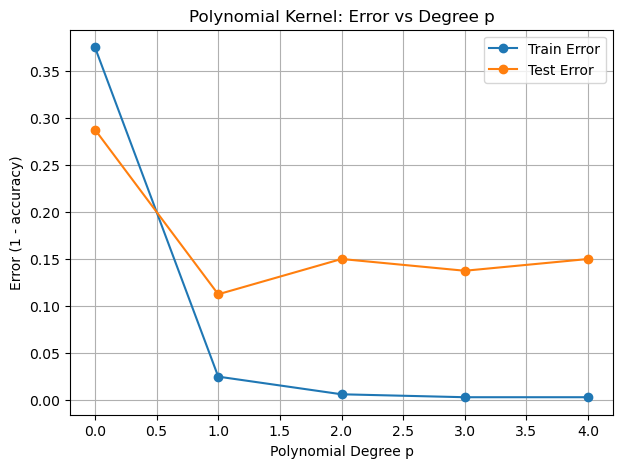

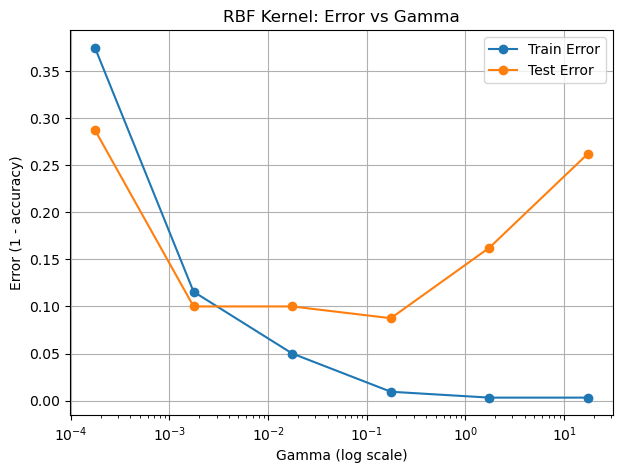

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Polynomial Kernel
# p = degree for polynomial kernel
p_list = [0, 1, 2, 3, 4] # as given in the question
# Create lists to store train and test errors
poly_train_err = []
poly_test_err = []
# Loop over each degree p
for p in p_list:
    # Define polynomial kernel function for current degree p
    def poly_k(x, y):
        # Call polynomial_kernel with c=1 and d=p
        return polynomial_kernel(x, y, c=1, d=p)

    # Create SVM and train, kernel_func set to poly_k
    svm_poly = SVM(kernel_func=poly_k, lambda_param=lambda_param) 
    svm_poly.train(train_data.inputs, train_data.labels)
    # Calculate train and test accuracy
    train_accuracy = svm_poly.accuracy(train_data.inputs, train_data.labels)
    test_accuracy = svm_poly.accuracy(test_data.inputs, test_data.labels)
    # Add errors to the lists
    poly_train_err.append(1 - train_accuracy)
    poly_test_err.append(1 - test_accuracy)

# Plot polynomial kernel errors
plt.figure(figsize=(7, 5))
plt.plot(p_list, poly_train_err, marker='o', label="Train Error")
plt.plot(p_list, poly_test_err, marker='o', label="Test Error")

plt.xlabel("Polynomial Degree p")
plt.ylabel("Error (1 - accuracy)")
plt.title("Polynomial Kernel: Error vs Degree p")
plt.grid(True)
plt.legend()
plt.show()


# RBF Kernel
# Get number of features
n_features = train_data.inputs.shape[1]
# Create list of gamma values as given in the question
gamma_list = [1000/n_features, 100/n_features,
            10/n_features,  1/n_features,
            0.1/n_features,0.01/n_features]
# Create lists to store train and test errors
rbf_train_err = []
rbf_test_err = []
# Loop over each gamma value
for gamma in gamma_list:
    # Define RBF kernel function for current gamma
    def rbf_k(x, y):
        # Call rbf_kernel with current gamma
        return rbf_kernel(x, y, gamma=gamma)

    # Create SVM and train, kernel_func set to rbf_k
    svm_rbf = SVM(kernel_func=rbf_k, lambda_param=lambda_param)
    svm_rbf.train(train_data.inputs, train_data.labels)
    # Calculate train and test accuracy
    train_accuracy = svm_rbf.accuracy(train_data.inputs, train_data.labels)
    test_accuracy = svm_rbf.accuracy(test_data.inputs, test_data.labels)
    # Add errors to the lists
    rbf_train_err.append(1 - train_accuracy)
    rbf_test_err.append(1 - test_accuracy)

# Plot RBF kernel errors
plt.figure(figsize=(7, 5))
plt.plot(gamma_list, rbf_train_err, marker='o', label="Train Error")
plt.plot(gamma_list, rbf_test_err, marker='o', label="Test Error")
# Use logarithmic scale for x-axis
plt.xscale("log")
plt.xlabel("Gamma (log scale)")
plt.ylabel("Error (1 - accuracy)")
plt.title("RBF Kernel: Error vs Gamma")
plt.grid(True)
plt.legend()
plt.show()


### **Question 4** (10 points)
Produce a visualization of the decision boundaries on
the both of the 2D datasets (`fake-data1.csv`, `fake-data2.csv`) for
two out of the three kernel functions. Your plot should contain the training data and
decision boundaries. In addition, the label of each training point
should be included. This should all be contained within a single
figure for each dataset.

**Hint:** Look into [matplotlib.pyplot.contour](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html#examples-using-matplotlib-pyplot-contour) and [numpy.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) to visualize the decision boundary.


**Solution:**

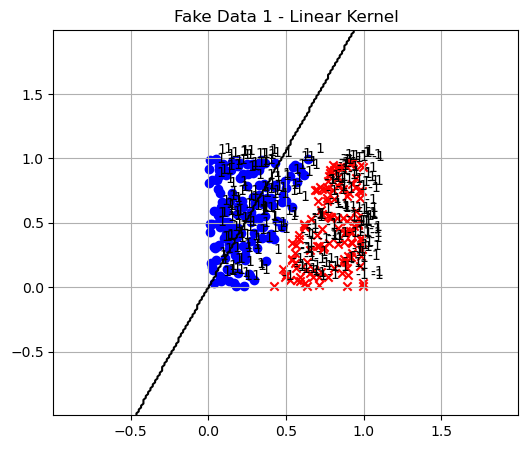

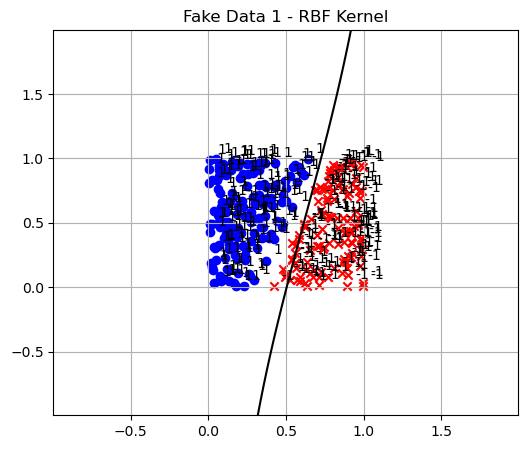

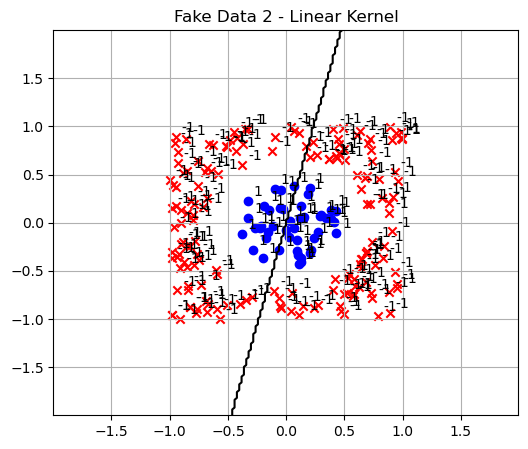

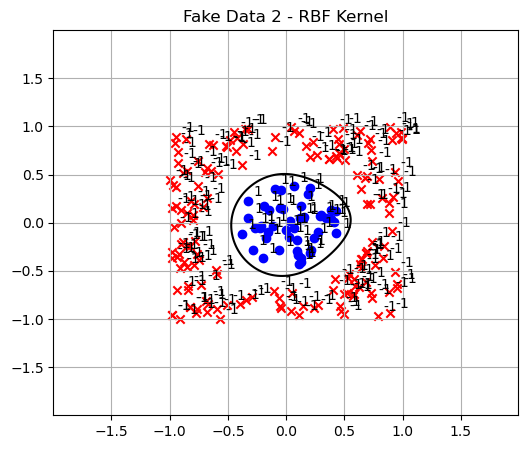

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load fake-data1.csv
df1 = pd.read_csv("data/fake-data1.csv", header=None)
# The first two columns are x, y
fake1_X = df1.iloc[:, 0:2].values
# The third column is the label
fake1_y = df1.iloc[:, 2].values
# Let's convert labels to {-1, 1}
fake1_y = np.where(fake1_y == 1, 1, -1)

# Load fake-data2.csv
df2 = pd.read_csv("data/fake-data2.csv", header=None)
fake2_X = df2.iloc[:, 0:2].values
fake2_y = df2.iloc[:, 2].values
fake2_y = np.where(fake2_y == 1, 1, -1)



# Fake Data 1: Linear Kernel
# Create and train SVM with linear kernel
svm_linear_1 = SVM(kernel_func=linear_kernel, lambda_param=0.1)
svm_linear_1.train(fake1_X, fake1_y)
# Plot decision boundary
plt.figure(figsize=(6,5))
# Define grid for plotting decision boundary
x_min = fake1_X[:,0].min() - 1
x_max = fake1_X[:,0].max() + 1
y_min = fake1_X[:,1].min() - 1
y_max = fake1_X[:,1].max() + 1
# Create meshgrid
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200))
# Use ravel and c_ to create grid points for prediction
grid_points = np.c_[xx.ravel(), yy.ravel()]
# Predict on grid points
Z = svm_linear_1.predict(grid_points)
Z = Z.reshape(xx.shape)
# Plot decision boundary where prediction is 0
plt.contour(xx, yy, Z, levels=[0], colors='k')
# Plot training data points with labels
# Loop over each training data point
for i in range(len(fake1_X)):
    # if label is 1, plot as blue circle
    if fake1_y[i] == 1:
        plt.scatter(fake1_X[i,0], fake1_X[i,1], c='b', marker='o')
    # if label is -1, plot as red x
    else:
        plt.scatter(fake1_X[i,0], fake1_X[i,1], c='r', marker='x')
    # Annotate each point with its label
    plt.text(fake1_X[i,0]+0.05, fake1_X[i,1]+0.05, str(fake1_y[i]))
plt.title("Fake Data 1 - Linear Kernel")
plt.grid(True)
plt.show()



# Fake Data 1: RBF Kernel
# Create and train SVM with RBF kernel
svm_rbf_1 = SVM(kernel_func=lambda a,b: rbf_kernel(a,b,gamma=1), lambda_param=0.1)
svm_rbf_1.train(fake1_X, fake1_y)
# Plot decision boundary
plt.figure(figsize=(6,5))
# Define grid for plotting decision boundary
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200))
# Use ravel and c_ to create grid points for prediction
grid_points = np.c_[xx.ravel(), yy.ravel()]
# compute continuous "score" value manually, outside the model
scores = []
for p in grid_points:
    s = 0
    for i in range(len(fake1_X)):
        s += svm_rbf_1.alpha[i] * svm_rbf_1.kernel_func(fake1_X[i], p)
    scores.append(s)
Z = np.array(scores)
Z = Z.reshape(xx.shape)
# Plot decision boundary where prediction is 0
plt.contour(xx, yy, Z, levels=[0], colors='k')
# Plot training data points with labels
# Loop over each training data point
for i in range(len(fake1_X)):
    # if label is 1, plot as blue circle
    if fake1_y[i] == 1:
        plt.scatter(fake1_X[i,0], fake1_X[i,1], c='b', marker='o')
    # if label is -1, plot as red x
    else:
        plt.scatter(fake1_X[i,0], fake1_X[i,1], c='r', marker='x')

    plt.text(fake1_X[i,0]+0.05, fake1_X[i,1]+0.05, str(fake1_y[i]))
plt.title("Fake Data 1 - RBF Kernel")
plt.grid(True)
plt.show()



# Fake Data 2: Linear Kernel
svm_linear_2 = SVM(kernel_func=linear_kernel, lambda_param=0.1)
svm_linear_2.train(fake2_X, fake2_y)

plt.figure(figsize=(6,5))

x_min = fake2_X[:,0].min() - 1
x_max = fake2_X[:,0].max() + 1
y_min = fake2_X[:,1].min() - 1
y_max = fake2_X[:,1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = svm_linear_2.predict(grid_points)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors='k')
for i in range(len(fake2_X)):
    if fake2_y[i] == 1:
        plt.scatter(fake2_X[i,0], fake2_X[i,1], c='b', marker='o')
    else:
        plt.scatter(fake2_X[i,0], fake2_X[i,1], c='r', marker='x')

    plt.text(fake2_X[i,0]+0.05, fake2_X[i,1]+0.05, str(fake2_y[i]))
plt.title("Fake Data 2 - Linear Kernel")
plt.grid(True)
plt.show()



#  Fake Data 2: RBF Kernel
# set gamma to 5 to capture the complex boundary
svm_rbf_2 = SVM(kernel_func=lambda a,b: rbf_kernel(a,b,gamma=5), lambda_param=0.1)
svm_rbf_2.train(fake2_X, fake2_y)

plt.figure(figsize=(6,5))

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200))

grid_points = np.c_[xx.ravel(), yy.ravel()]
scores = []
for p in grid_points:
    s = 0
    for i in range(len(fake2_X)):
        s += svm_rbf_2.alpha[i] * svm_rbf_2.kernel_func(fake2_X[i], p)
    scores.append(s)
Z = np.array(scores)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors='k')
for i in range(len(fake2_X)):
    if fake2_y[i] == 1:
        plt.scatter(fake2_X[i,0], fake2_X[i,1], c='b', marker='o')
    else:
        plt.scatter(fake2_X[i,0], fake2_X[i,1], c='r', marker='x')

    plt.text(fake2_X[i,0]+0.05, fake2_X[i,1]+0.05, str(fake2_y[i]))
plt.title("Fake Data 2 - RBF Kernel")
plt.grid(True)
plt.show()
